In [16]:
# %tensorflow_version 1.x
try:
  %tensorflow_version 1.x # Colab only
except Exception:
    pass

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # Colab only`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [32]:
import numpy as np
import tensorflow as tf
from scipy import signal as sig
# import scipy.io
# from numpy import fft
# from plotting import newfig, savefig
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('style/elegant.mplstyle')
print(tf.__version__)

1.15.2


In [18]:
from google.colab import drive
drive.mount('/content/gdrive')
# filePath = '/content/gdrive/My Drive/Colab Notebooks/stepFunction'

Mounted at /content/gdrive


In [33]:
np.random.seed(1234)
tf.set_random_seed(1234)
# np.set_printoptions(threshold=sys.maxsize)

In [34]:
### Function for approximation ###
def step_function(x):
    # noise = np.random.normal(0, 0.1, 1)
    f = np.zeros(len(x))
    f = np.reshape(f,(-1, 1))
    for i in range(len(x)):
        if x[i] < 0:
            # f[i] = 0.2 * np.sin(6*x[i]) #+ np.random.normal(0, 0.001, 1)
            f[i] = 0
        else:
            # f[i] = 1 + 0.1 * x[i] * np.cos(18*x[i]) #+ np.random.normal(0, 0.001, 1)
            f[i] = 1
    return f

## Function for approximation
def non_linear_step_function(x):
    # noise = np.random.normal(0, 0.1, 1)
    f = np.zeros(len(x))
    f = np.reshape(f,(-1, 1))
    for i in range(len(x)):
        if x[i] < 0:
            f[i] = 0.2 * np.sin(6*x[i]) #+ np.random.normal(0, 0.001, 1)
            # f[i] = 0
        else:
            f[i] = 1 + 0.1 * x[i] * np.cos(18*x[i]) #+ np.random.normal(0, 0.001, 1)
            # f[i] = 1
    return f


## Function for approximation
def smooth_function(x):
    # noise = np.random.normal(0, 0.1, 1)
    f = np.zeros(len(x))
    f = np.reshape(f,(-1, 1))
    for i in range(len(x)):
        f[i] = (x[i]**3 - x[i])*(np.sin(7*x[i]) / 7.0) + np.sin(12*x[i])
    return f


In [35]:
# def hyper_parameters_A(size):
#     a = tf.Variable(tf.constant(0.1, shape=size))
#     return a

# def hyper_parameters(size):
#     return tf.Variable(tf.random_normal(shape=size, mean=0.0, stddev=0.1))

def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev = xavier_stddev),dtype=tf.float32)

def hyper_parameters_A(size):
    a = tf.Variable(tf.constant(0.1, shape=size))
    return a

def hyper_parameters_B(size):
    a = tf.Variable(tf.constant(0.1, shape=size))
    return a


# def hyper_parameters_B(size):
#     b = tf.Variable(tf.constant(0.1, shape=size))
#     return b

def hyper_parameters(size):
    # return tf.Variable(tf.random_normal(shape=size, mean = 0.0, stddev= 0.1))
    return tf.Variable(xavier_init(size=size))

def DNN(X, W, b, a_NLLAF, a_LLLAF, lb, ub):
    A =  X #2.0 * (X - lb) / (ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        if i % 2 == 0:
            A = a_LLLAF[i]*tf.sin(10*a_NLLAF[i]*tf.add(tf.matmul(A, W[i]), b[i]))
        else:
            A = a_LLLAF[i]*tf.tanh(10*a_NLLAF[i]*tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def predict():
    pass

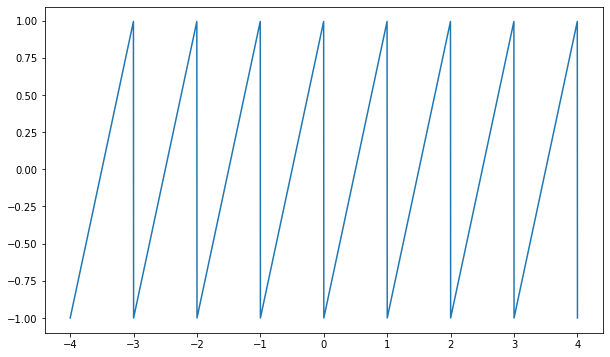

In [52]:
N = 3000
x = np.linspace(-4, 4, N + 1)
lb = x[0] # lower bound
ub = x[-1] # upper bound
x = np.reshape(x, (-1, 1))

# # N = 300
# t = np.linspace(-1, 1, N + 1)
# y = np.sin(np.tanh(t))
# # y_ = np.cos(np.sin(t))
# y = np.sin(2*np.pi*x)
# y = non_linear_step_function(y)
y = sig.sawtooth(2 * np.pi * 1 * x)
fig = plt.figure(figsize=[10,6])
# plt.plot(x,y)
plt.plot(x, y)
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/sawtooth_wave.png')

In [40]:
layers = [1] + 10*[1000] + [1]
W = [hyper_parameters([layers[l-1], layers[l]]) for l in range(1, len(layers))]
b = [hyper_parameters([1, layers[l]]) for l in range(1, len(layers))]
a_NLLAF = [hyper_parameters_A([1, layers[l]]) for l in range(1, len(layers))]
a_LLLAF = [hyper_parameters_B([1, 1]) for l in range(1, len(layers))]
# # print(a)

In [41]:
## Slope recovery term
def S(a):
    y = 0
    for i in range(0, len(a)):
        y += tf.tanh(tf.reduce_mean(a[i]))
    slope_term = 1/(tf.reduce_mean(y)) 
    return slope_term

In [53]:
# layers = [1] + 10*[50] + [1]
# print(layers)
x_train = tf.placeholder(tf.float32, shape=[None, 1])
y_train = tf.placeholder(tf.float32, shape=[None, 1])
y_pred = DNN(x_train, W, b, a_NLLAF, a_LLLAF, lb, ub)
loss = tf.reduce_mean(tf.square(y_pred - y_train)) + S(a_NLLAF) + S(a_NLLAF)

# loss = tf.reduce_mean(tf.square(y_pred - y_train)) + (1.0 / (tf.reduce_mean(tf.exp(tf.reduce_mean(
#         a[0])) + tf.exp(tf.reduce_mean(a[1])) + tf.exp(tf.reduce_mean(a[2])) + tf.exp(tf.reduce_mean(a[3])) + tf.exp(tf.reduce_mean(a[4])))))

# loss = tf.reduce_mean(tf.square(y_pred - y_train)) + (1.0 / (tf.reduce_mean(tf.exp(tf.reduce_mean(
#         a[0])) + tf.exp(tf.reduce_mean(a[1])) + tf.exp(tf.reduce_mean(a[2])) + tf.exp(tf.reduce_mean(a[3])) + tf.exp(tf.reduce_mean(a[4])) 
#             + tf.exp(tf.reduce_mean(a[5])))))

MSE_history = []
Solution_history = []
for i in range(1, 2):
    
    # train = tf.train.AdamOptimizer(10**-i).minimize(loss)
    train = tf.train.AdamOptimizer(1.0e-4).minimize(loss)

    sess = tf.Session()

    init = tf.global_variables_initializer()   


    sess.run(init)
    nmax = 60000
    n = 0

    MSE_hist = []
    Sol = []
    # a_hist = []

    print("For Learning rate = ", 10**-4)

    while n <= nmax:
        n = n + 1
        loss_, _, y_ = sess.run([loss, train, y_pred], feed_dict={x_train: x, y_train: y})
        err = loss_
        # a_value = sess.run(a, feed_dict={x_train: x, y_train: y})
        # a_value = np.concatenate(a_value, axis=1)
        # a_value = np.reshape(a_value, (-1, 1))
        # a_hist.append(a_value)

        MSE_hist.append(err)    # a_hist = []
        # print(y_.shape)

        if n == 20000 or n == 40000 or n == 60000:
            # Sol.append(y_)
            # print(y_.shape)
            print('Steps : %d, loss: %0.3e'%(n, loss_))
        if n == 60000:
            Sol.append(y_)
    
    MSE_history.append(MSE_hist)
    Solution_history.append(Sol)

For Learning rate =  0.0001
Steps : 20000, loss: 3.658e-01
Steps : 40000, loss: 2.827e-01
Steps : 60000, loss: 2.343e-01


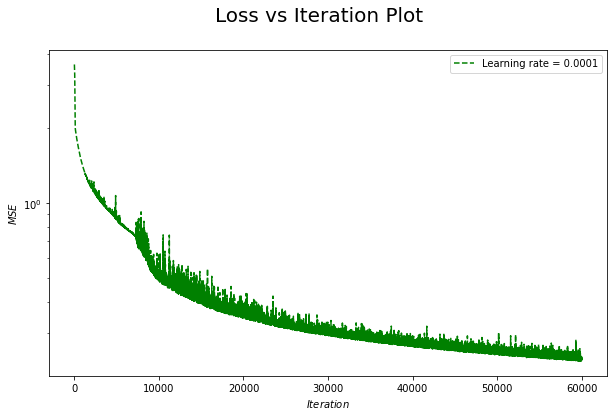

In [54]:
fig = plt.figure(figsize=[10, 6])
plt.semilogy(MSE_history[0], 'g--', label = 'Learning rate = 0.0001')
# plt.semilogy(MSE_history[1], 'r--', label = 'Learning rate = 0.01')
# plt.semilogy(MSE_history[2], 'b--', label = 'Learning rate = 0.001')
# plt.semilogy(MSE_history[3], 'y--', label = 'Learning rate = 0.0001')
# plt.semilogy(MSE_history[4], 'k--', label = 'Learning rate = 0.00001')
# plt.semilogy(MSE_history[5], 'c--', label = 'Learning rate = 0.000001')
# plt.semilogy(MSE_history[6], 'b-', label = 'Learning rate = 0.0000001')
plt.xlabel('$Iteration$')
plt.ylabel('$MSE$')
plt.legend(loc='best')
fig.suptitle('Loss vs Iteration Plot', fontsize=20)
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/MSE_Loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

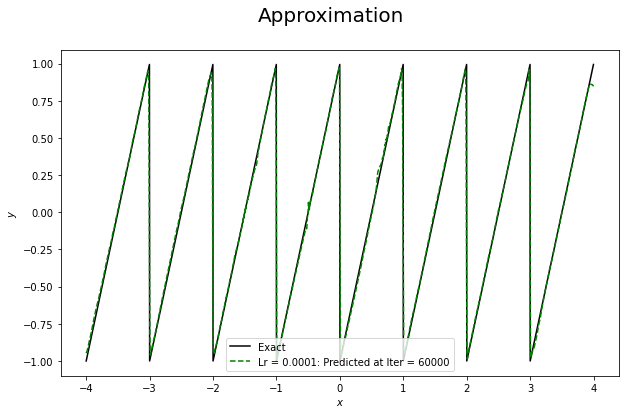

In [55]:
Sol_15000_1 = np.asarray(Solution_history[0]).reshape(len(x),1)
# Sol_15000_2 = np.asarray(Solution_history[1]).reshape(len(x),1)
# Sol_15000_3 = np.asarray(Solution_history[2]).reshape(len(x),1)
# Sol_15000_4 = np.asarray(Solution_history[3]).reshape(len(x),1)
# Sol_15000_5 = np.asarray(Solution_history[4]).reshape(len(x),1)
# Sol_15000_6 = np.asarray(Solution_history[5]).reshape(len(x),1)

fig = plt.figure(figsize=[10,6])
plt.plot(x[0:-1], y[0:-1], 'k',  label = 'Exact')
plt.plot(x[0:-1], Sol_15000_1[0:-1,-1], 'g--',  label = 'Lr = 0.0001: Predicted at Iter = 60000')
# plt.plot(x[0:-1], Sol_15000_2[0:-1,-1], 'r--',  label = 'Lr = 0.01: Predicted at Iter = 15000')
# plt.plot(x[0:-1], Sol_15000_3[0:-1,-1], 'b--',  label = 'Lr = 0.001: Predicted at Iter = 15000')
# plt.plot(x[0:-1], Sol_15000_4[0:-1,-1], 'y--',  label = 'Lr = 0.0001: Predicted at Iter = 15000')
# plt.plot(x[0:-1], Sol_15000_5[0:-1,-1], 'k--',  label = 'Lr = 0.00001: Predicted at Iter = 15000')
# plt.plot(x[0:-1], Sol_15000_6[0:-1,-1], 'c--',  label = 'Lr = 0.000001: Predicted at Iter = 15000')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best')
fig.suptitle('Approximation', fontsize=20)
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Approx_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')

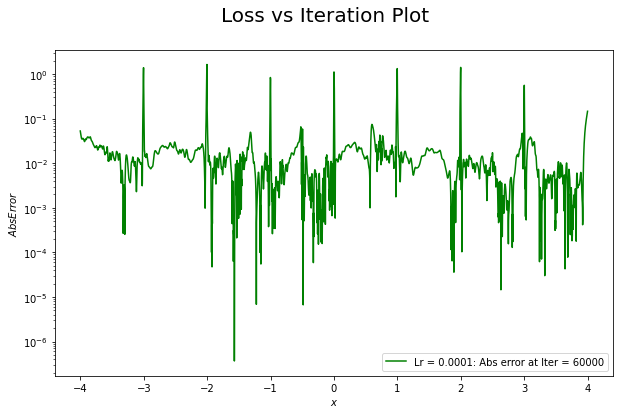

In [56]:
Sol_15000_1 = np.asarray(Solution_history[0]).reshape(len(x),1)[0:-1,-1].flatten()[:, None]
error_15000_1 = np.abs(Sol_15000_1 - y[0:-1])
# Sol_15000_2 = np.asarray(Solution_history[1]).reshape(3001,1)[0:-1,-1].flatten()[:, None]
# error_15000_2 = np.abs(Sol_15000_2 - y[0:-1])
# Sol_15000_3 = np.asarray(Solution_history[2]).reshape(3001,1)[0:-1,-1].flatten()[:, None]
# error_15000_3 = np.abs(Sol_15000_3 - y[0:-1])
# Sol_15000_4 = np.asarray(Solution_history[3]).reshape(3001,1)[0:-1,-1].flatten()[:, None]
# error_15000_4 = np.abs(Sol_15000_4 - y[0:-1])
# Sol_15000_5 = np.asarray(Solution_history[4]).reshape(3001,1)[0:-1,-1].flatten()[:, None]
# error_15000_5 = np.abs(Sol_15000_5 - y[0:-1])
# Sol_15000_6 = np.asarray(Solution_history[5]).reshape(3001,1)[0:-1,-1].flatten()[:, None]
# error_15000_6 = np.abs(Sol_15000_6 - y[0:-1])

fig = plt.figure(figsize=[10, 6])
plt.semilogy(x[0:-1], error_15000_1, 'g', label = 'Lr = 0.0001: Abs error at Iter = 60000')
# plt.semilogy(x[0:-1], error_15000_2, 'r', label = 'Lr = 0.01: Abs error at Iter = 15000')
# plt.semilogy(x[0:-1], error_15000_3, 'b', label = 'Lr = 0.001: Abs error at Iter = 15000')
# plt.semilogy(x[0:-1], error_15000_4, 'y', label = 'Lr = 0.0001: Abs error at Iter = 15000')
# plt.semilogy(x[0:-1], error_15000_5, 'k', label = 'Lr = 0.00001: Abs error at Iter = 15000')
# plt.semilogy(x[0:-1], error_15000_3, 'c--', label = 'Lr = 0.000001: Abs error at Iter = 15000')
plt.xlabel('$x$')
plt.ylabel('$Abs Error$')
plt.legend(loc='best')
# plt.legend(loc='best')
fig.suptitle('Loss vs Iteration Plot', fontsize=20)
fig.savefig('/content/gdrive/My Drive/Colab Notebooks/stepFunction/Abs_loss_adam_lr:0.0001_N=3000_Itr=60000_sawtooth_layers = [1] + 10*[1000] + [1].png')